In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

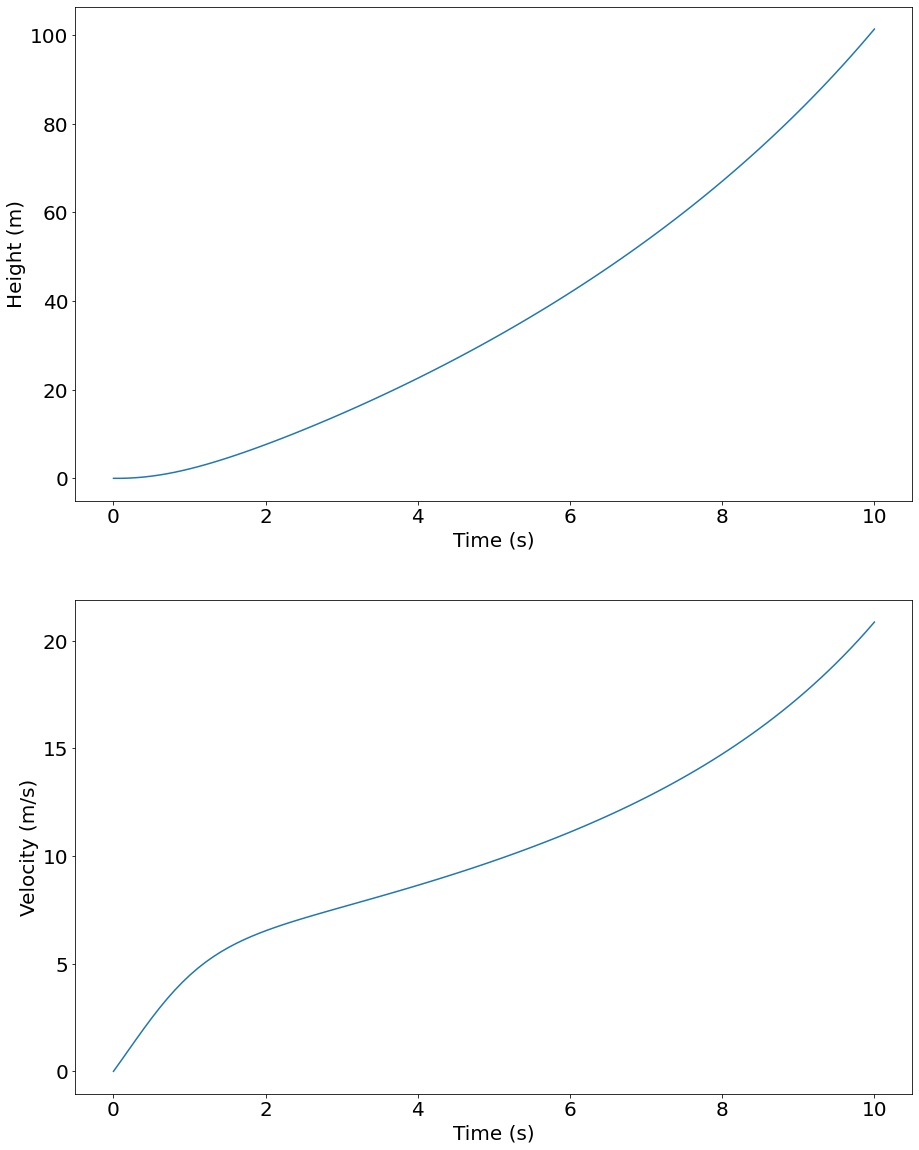

In [2]:
# Define the scenario.

dt = 0.1  # Time step
n = 100   # Duration (in time steps)
t = np.linspace(0, dt * n, n)

# Constants/functions for (exceedingly fictional) drag model
surface_atm_density = 3e-2  # Atmospheric density at the surface (Pa)
calc_atm_density = lambda height: surface_atm_density * (1 - 3e-3 * height) ** 5
def calc_drag(height, velocity):
    atm_density = calc_atm_density(height)
    return 0.5 * atm_density * velocity ** 2

commanded_acceleration = 5 + 0.1 * np.arange(n)
true_acceleration = commanded_acceleration.copy()
true_velocity = np.zeros(n)
true_height = np.zeros(n)

# Account for drag
for k in range(1, n):
    drag = calc_drag(true_height[k-1], true_velocity[k-1])
    true_velocity[k] = true_velocity[k-1] + true_acceleration[k-1] * dt - drag
    true_height[k] = true_height[k-1] + true_velocity[k-1] * dt

plt.figure(figsize=(15, 20))
plt.rc("font", size=20)
plt.subplot(2, 1, 1)
plt.plot(t, true_height, label="Height")
plt.ylabel("Height (m)")
plt.xlabel("Time (s)")
plt.subplot(2, 1, 2)
plt.plot(t, true_velocity, label="Velocity")
plt.ylabel("Velocity (m/s)")
plt.xlabel("Time (s)")
plt.show()

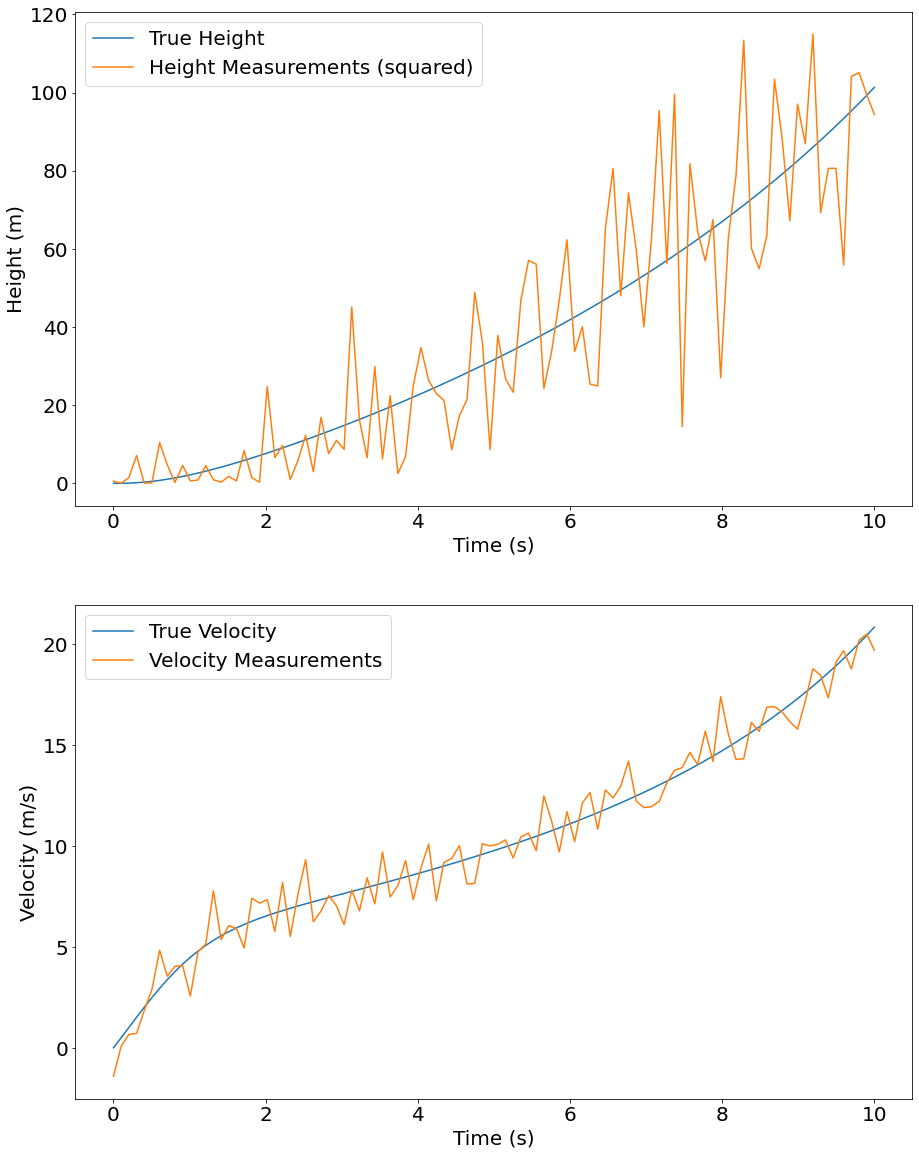

Height Error:
  Sensor only:    15.275 m (RMS)
Velocity Error:
  Sensor only:    0.949 m/s (RMS)


In [3]:
# Sensors only.

height_variance = np.sqrt(5)
velocity_variance = 1

height_measurements = np.sqrt(true_height) + np.random.normal(0, np.sqrt(height_variance), n)
velocity_measurements = true_velocity + np.random.normal(0, np.sqrt(velocity_variance), n)

height_measurement_error = true_height - height_measurements**2
velocity_measurement_error = true_velocity - velocity_measurements
height_measurement_rms_error = np.sqrt(np.mean(height_measurement_error**2))
velocity_measurement_rms_error = np.sqrt(np.mean(velocity_measurement_error**2))

plt.figure(figsize=(15, 20))
plt.rc("font", size=20)
plt.subplot(2, 1, 1)
plt.plot(t, true_height, label="True Height")
plt.plot(t, height_measurements**2, label="Height Measurements (squared)")
plt.legend()
plt.ylabel("Height (m)")
plt.xlabel("Time (s)")
plt.subplot(2, 1, 2)
plt.plot(t, true_velocity, label="True Velocity")
plt.plot(t, velocity_measurements, label="Velocity Measurements")
plt.legend()
plt.ylabel("Velocity (m/s)")
plt.xlabel("Time (s)")
plt.show()

print("Height Error:")
print(f"  Sensor only:    {height_measurement_rms_error:0.3f} m (RMS)")
print("Velocity Error:")
print(f"  Sensor only:    {velocity_measurement_rms_error:0.3f} m/s (RMS)")

In [4]:
class KalmanFilter:
    
    def __init__(self):
        pass
    
    @staticmethod
    def _prediction_step(x, P, u, A, B, Q):
        x = A @ x + B * u
        P = A @ P @ A.T + Q
        return x, P
    
    @staticmethod
    def _correction_step(x, P, z, H, R):
        y = z - H @ x
        S = H @ P @ H.T + R
        K = P @ H.T @ np.linalg.inv(S)
        x = x + K @ y
        P = (np.eye(len(x)) - K @ H) @ P
        return x, P
    
    def estimate(self, measurements, control_inputs, A, B, Q, H, R, x_init, P_init):
        estimates = np.empty_like(measurements)
        estimates_cov = np.empty_like(measurements)
        estimates[0] = x_init.flatten()
        estimates_cov[0] = [P_init[0, 0], P_init[1, 1]]
        x, P = x_init, P_init
        for k in range(1, n):
            u = 0 if control_inputs is None else control_inputs[k-1]
            z = measurements[k, :, np.newaxis]  # np.newaxis because we need shape (n, 1) not (n,)
            x, P = self._prediction_step(x, P, u, A, B, Q)
            x, P = self._correction_step(x, P, z, H, R)
            estimates[k] = x.flatten()
            estimates_cov[k] = [P[0, 0], P[1, 1]]
        return estimates, estimates_cov
    
    @staticmethod
    def plot(t, ground_truth, measurements, estimates, estimates_cov, state_variable_names):
        state_dim = ground_truth.shape[1]
        plt.figure(figsize=(15, 10 * state_dim))
        plt.rc("font", size=20)
        for i in range(state_dim):
            plt.subplot(state_dim, 1, i+1)
            plt.title(f"{state_variable_names[i]} Estimation")
            plt.plot(t, ground_truth[:,i], label=f"True {state_variable_names[i]}", color="blue")
            plt.plot(t, measurements[:,i], label=f"Measured {state_variable_names[i]}", color="orange")
            plt.plot(t, estimates[:,i], label=f"Estimated {state_variable_names[i]}", color="green")
            plt.fill_between(t, estimates[:,i] - np.sqrt(estimates_cov[:,i]),
                             estimates[:,i] + np.sqrt(estimates_cov[:,i]),
                             label="Estimate +/- 1 std. dev.", alpha=0.2, color="green")
            plt.legend()
            plt.xlabel("Time (s)")
            plt.ylabel(f"{state_variable_names[i]}")
        plt.show()
    
    @staticmethod
    def display_errors(ground_truth, measurements, estimates, state_variable_names):
        state_dim = ground_truth.shape[1]
        for i in range(state_dim):
            # NOTE: Ignore initial state estimate to allow estimator one time step
            #       to converge. Otherwise a bad initial estimate will make the
            #       calculated error huge. (RMS is very sensitive to outliers.)
            sensor_rms = np.sqrt(np.mean((ground_truth[1:,i] - measurements[1:,i])**2))
            estimator_rms = np.sqrt(np.mean((ground_truth[1:,i] - estimates[1:,i])**2))
            print(f"RMS Error {state_variable_names[i]}:")
            print(f"  Sensor:    {sensor_rms:0.3f}")
            print(f"  Estimator: {estimator_rms:0.3f}")
    
    def simulate(self, ground_truth, measurements, state_variable_names,
                 control_inputs, t, A, B, Q, H, R, x_init, P_init):
        estimates, estimates_cov = self.estimate(measurements, control_inputs, A, B, Q, H, R, x_init, P_init)
        
        self.plot(t, ground_truth, measurements, estimates, estimates_cov, state_variable_names)

        self.display_errors(ground_truth, measurements, estimates, state_variable_names)

In [5]:
class ExtendedKalmanFilter:
    
    def __init__(self):
        pass
    
    @staticmethod
    def _prediction_step(x, P, u, Q, process_model, process_model_jacobian):
        F = process_model_jacobian(x, u)  # Linearize process model about x[k-1].
        x = process_model(x, u)  # Advance state using full, nonlinear process model.
        P = F @ P @ F.T + Q  # Advance state covariance using linearized process model F.
        return x, P
    
    @staticmethod
    def _correction_step(x, P, z, R, measurement_model, measurement_model_jacobian):
        H = measurement_model_jacobian(x)  # Linearize measurement model about predicted x.
        y = z - measurement_model(x)  # Calculate measurement residual using full, nonlinear measurement model.
        S = H @ P @ H.T + R  # Linearized measurement model H is used in remaining calculations.
        K = P @ H.T @ np.linalg.inv(S)
        x = x + K @ y
        P = (np.eye(len(P)) - K @ H) @ P
        return x, P
    
    def estimate(self, measurements, control_inputs, Q, R, x_init, P_init,
                 process_model, process_model_jacobian,
                 measurement_model, measurement_model_jacobian):
        estimates = np.empty_like(measurements)
        estimates_cov = np.empty_like(measurements)
        estimates[0] = x_init.flatten()
        estimates_cov[0] = [P_init[0, 0], P_init[1, 1]]
        x, P = x_init, P_init
        for k in range(1, n):
            u = 0 if control_inputs is None else control_inputs[k-1]
            z = measurements[k, :, np.newaxis]  # np.newaxis because we need shape (n, 1) not (n,)
            x, P = self._prediction_step(x, P, u, Q, process_model, process_model_jacobian)
            x, P = self._correction_step(x, P, z, R, measurement_model, measurement_model_jacobian)
            estimates[k] = x.flatten()
            estimates_cov[k] = [P[0, 0], P[1, 1]]
        return estimates, estimates_cov
    
    @staticmethod
    def plot(t, ground_truth, measurements, estimates, estimates_cov, state_variable_names, measurement_model):
        state_dim = ground_truth.shape[1]
        for k in range(measurements.shape[0]):
            measurements[k] = measurement_model(measurements[k]).flatten()
        plt.figure(figsize=(15, 10 * state_dim))
        plt.rc("font", size=20)
        for i in range(state_dim):
            plt.subplot(state_dim, 1, i+1)
            plt.title(f"{state_variable_names[i]} Estimation")
            plt.plot(t, ground_truth[:,i], label=f"True {state_variable_names[i]}", color="blue")
            plt.plot(t, measurements[:,i], label=f"Measured {state_variable_names[i]}", color="orange")
            plt.plot(t, estimates[:,i], label=f"Estimated {state_variable_names[i]}", color="green")
            plt.fill_between(t, estimates[:,i] - np.sqrt(estimates_cov[:,i]),
                             estimates[:,i] + np.sqrt(estimates_cov[:,i]),
                             label="Estimate +/- 1 std. dev.", alpha=0.2, color="green")
            plt.legend()
            plt.xlabel("Time (s)")
            plt.ylabel(f"{state_variable_names[i]}")
        plt.show()
    
    @staticmethod
    def display_errors(ground_truth, measurements, estimates, state_variable_names):
        state_dim = ground_truth.shape[1]
        for i in range(state_dim):
            # NOTE: Ignore initial state estimate to allow estimator one time step
            #       to converge. Otherwise a bad initial estimate will make the
            #       calculated error huge. (RMS is very sensitive to outliers.)
            sensor_rms = np.sqrt(np.mean((ground_truth[1:,i] - measurements[1:,i])**2))
            estimator_rms = np.sqrt(np.mean((ground_truth[1:,i] - estimates[1:,i])**2))
            print(f"RMS Error {state_variable_names[i]}:")
            print(f"  Sensor:    {sensor_rms:0.3f}")
            print(f"  Estimator: {estimator_rms:0.3f}")
    
    def simulate(self, ground_truth, measurements, state_variable_names,
                 control_inputs, t, Q, R, x_init, P_init,
                 process_model, process_model_jacobian,
                 measurement_model, measurement_model_jacobian):
        estimates, estimates_cov = self.estimate(measurements, control_inputs, Q, R, x_init, P_init,
                                                 process_model, process_model_jacobian,
                                                 measurement_model, measurement_model_jacobian)
        
        self.plot(t, ground_truth, measurements, estimates, estimates_cov, state_variable_names, measurement_model)

        self.display_errors(ground_truth, measurements, estimates, state_variable_names)

In [6]:
# Kalman filter with control input as well as height and velocity sensors.

# EKF functions for state transition and measurement model
def process_model(x, u):
    height, velocity = x.flatten()
    drag = calc_drag(height, velocity)
    new_height = height + velocity * dt
    new_velocity = velocity - drag + u * dt
    return np.array([[new_height],
                     [new_velocity]])

def process_model_jacobian(x, u):
    height, velocity = x.flatten()
    
    # Calculate elements of the Jacobian matrix F
    F11 = 1.                                   # Partial derivative of new_height with respect to height
    F12 = dt                                   # Partial derivative of new_height with respect to velocity
    F21 = 2.25e-4 * (1 - 0.003 * height) ** 4  # Partial derivative of new_velocity with respect to height
    F22 = 1 - 0.3 * (1 - 0.003 * height) ** 5  # Partial derivative of new_velocity with respect to velocity
    
    # Construct the Jacobian matrix F
    F = np.array([[F11, F12],
                  [F21, F22]])
    return F

def measurement_model(x):
    height, velocity = x.flatten()
    height = max(height, np.finfo(float).eps)
    return np.array([[np.sqrt(height)],
                     [velocity]])

def measurement_model_jacobian(x):
    height, velocity = x.flatten()
    height = max(height, np.finfo(float).eps)
    H = np.array([[0.5 / np.sqrt(height), 0],
                  [0, 1]])
    return H

In [7]:
commanded_acceleration = 5 + 0.1 * np.arange(n)
true_acceleration = commanded_acceleration.copy()
true_velocity = np.zeros(n)
true_height = np.zeros(n)

# Account for drag
for k in range(1, n):
    drag = calc_drag(true_height[k-1], true_velocity[k-1])
    true_velocity[k] = true_velocity[k-1] + true_acceleration[k-1] * dt - drag
    true_height[k] = true_height[k-1] + true_velocity[k-1] * dt

height_measurements = np.sqrt(true_height) + np.random.normal(0, np.sqrt(height_variance), n)
velocity_measurements = true_velocity + np.random.normal(0, np.sqrt(velocity_variance), n)

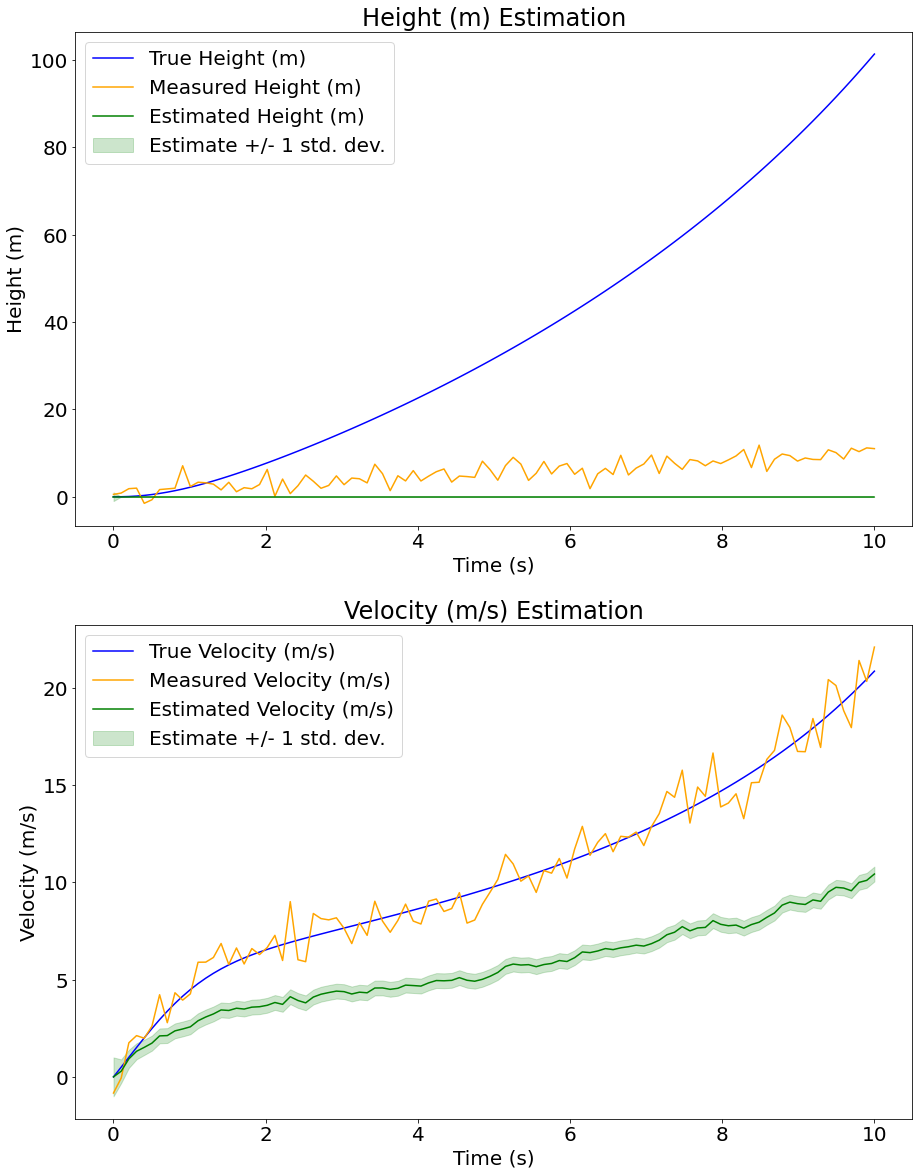

RMS Error Height (m):
  Sensor:    42.079
  Estimator: 48.009
RMS Error Velocity (m/s):
  Sensor:    0.887
  Estimator: 5.408


In [8]:
### Simulation #1
#
# Linearize about the starting point and use a linear Kalman Filter.

# Initial state and covariance estimates
x = np.array([[0.0],
              [0.0]])
P = np.array([[1., 0.],
              [0., 1.]])

# Process noise covariance
Q = np.array([[0.1, 0],
              [0, 0.1]])

# Measurement noise covariance
R = np.array([[height_variance, 0],
              [0, velocity_variance]])

# Define our control input matrix.
B = np.array([[0.5 * dt**2],
              [dt]])

A = process_model_jacobian(x, commanded_acceleration[0])

H = measurement_model_jacobian(x)

# Construct our estimator and run it in simulation.
kf = KalmanFilter()
kf.simulate(
    ground_truth=np.vstack((true_height, true_velocity)).T,
    measurements=np.vstack((height_measurements, velocity_measurements)).T,
    state_variable_names=["Height (m)", "Velocity (m/s)"],
    control_inputs=commanded_acceleration,
    t=t, A=A, B=B, Q=Q, H=H, R=R, x_init=x, P_init=P
)

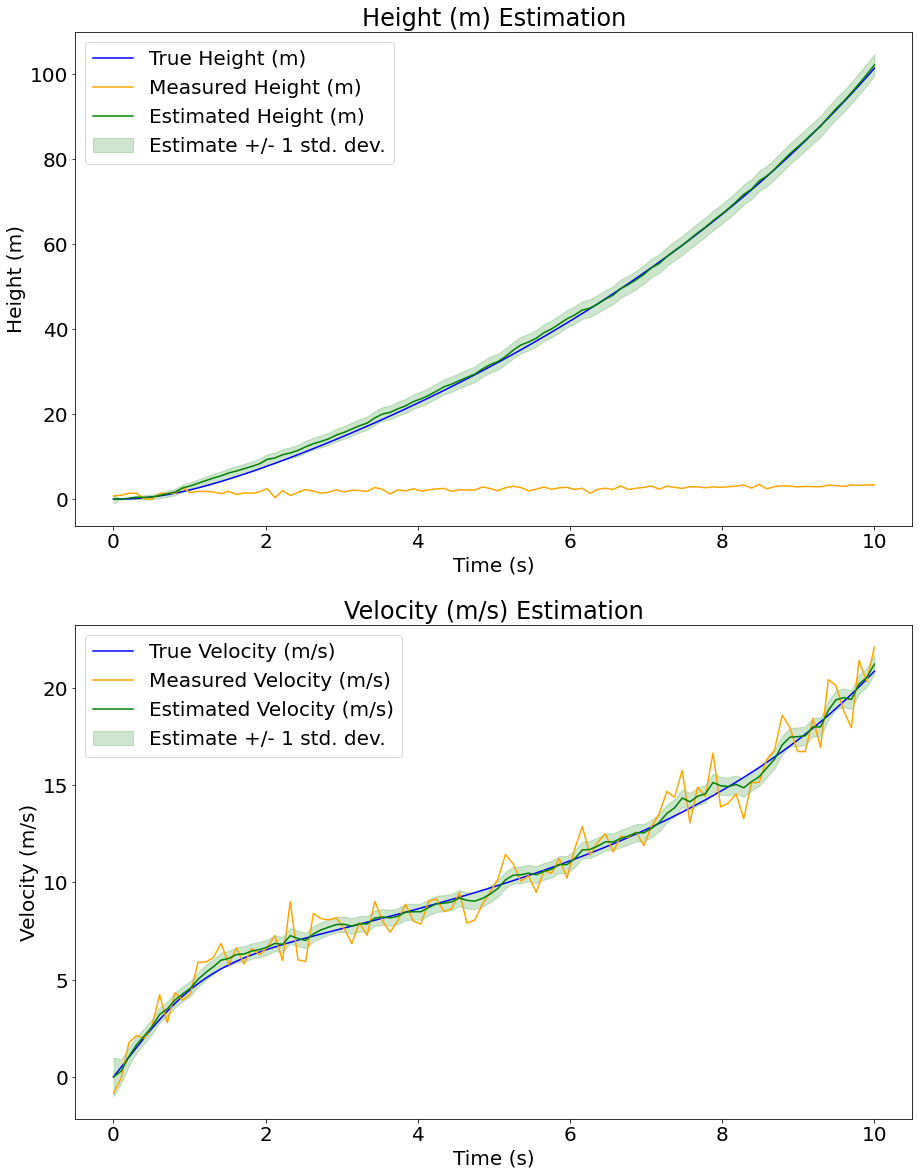

RMS Error Height (m):
  Sensor:    45.887
  Estimator: 0.725
RMS Error Velocity (m/s):
  Sensor:    0.887
  Estimator: 0.248


In [9]:
### Simulation #2
#
# Use an EKF.

# Initial state and covariance estimates
x = np.array([[0.0],
              [0.0]])
P = np.array([[1., 0.],
              [0., 1.]])

# Process noise covariance
Q = np.array([[0.1, 0],
              [0, 0.1]])

# Measurement noise covariance
R = np.array([[height_variance, 0],
              [0, velocity_variance]])

ekf = ExtendedKalmanFilter()
ekf.simulate(
    ground_truth=np.vstack((true_height, true_velocity)).T,
    measurements=np.vstack((height_measurements, velocity_measurements)).T,
    state_variable_names=["Height (m)", "Velocity (m/s)"],
    control_inputs=commanded_acceleration,
    t=t, Q=Q, R=R, x_init=x, P_init=P,
    process_model=process_model, process_model_jacobian=process_model_jacobian,
    measurement_model=measurement_model, measurement_model_jacobian=measurement_model_jacobian
)

In [10]:
commanded_acceleration = 5 + 0.1 * np.arange(n)
true_acceleration = commanded_acceleration.copy()
true_acceleration[20:40] = 0
true_velocity = np.zeros(n)
true_height = np.zeros(n)

# Account for drag
for k in range(1, n):
    drag = calc_drag(true_height[k-1], true_velocity[k-1])
    true_velocity[k] = true_velocity[k-1] + true_acceleration[k-1] * dt - drag
    true_height[k] = true_height[k-1] + true_velocity[k-1] * dt

height_measurements = np.sqrt(true_height) + np.random.normal(0, np.sqrt(height_variance), n)
velocity_measurements = true_velocity + np.random.normal(0, np.sqrt(velocity_variance), n)

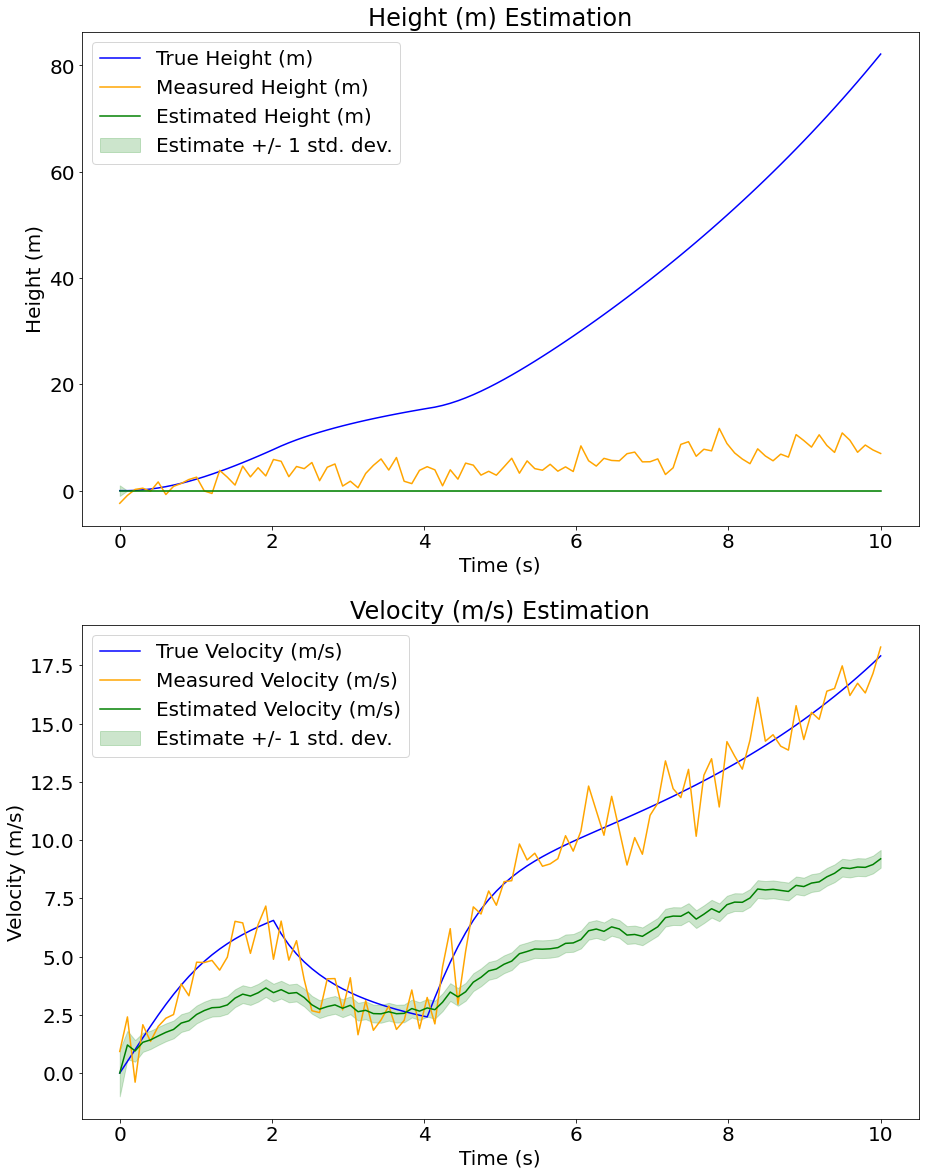

RMS Error Height (m):
  Sensor:    32.216
  Estimator: 37.261
RMS Error Velocity (m/s):
  Sensor:    0.926
  Estimator: 4.368


In [11]:
### Simulation #3
#
# See how a linear Kalman Filter handles a large disturbance.

# Initial state and covariance estimates
x = np.array([[0.0],
              [0.0]])
P = np.array([[1., 0.],
              [0., 1.]])

# Process noise covariance
Q = np.array([[0.1, 0],
              [0, 0.1]])

# Measurement noise covariance
R = np.array([[height_variance, 0],
              [0, velocity_variance]])

# Define our control input matrix.
B = np.array([[0.5 * dt**2],
              [dt]])

A = process_model_jacobian(x, commanded_acceleration[0])

H = measurement_model_jacobian(x)

# Construct our estimator and run it in simulation.
kf = KalmanFilter()
kf.simulate(
    ground_truth=np.vstack((true_height, true_velocity)).T,
    measurements=np.vstack((height_measurements, velocity_measurements)).T,
    state_variable_names=["Height (m)", "Velocity (m/s)"],
    control_inputs=commanded_acceleration,
    t=t, A=A, B=B, Q=Q, H=H, R=R, x_init=x, P_init=P
)

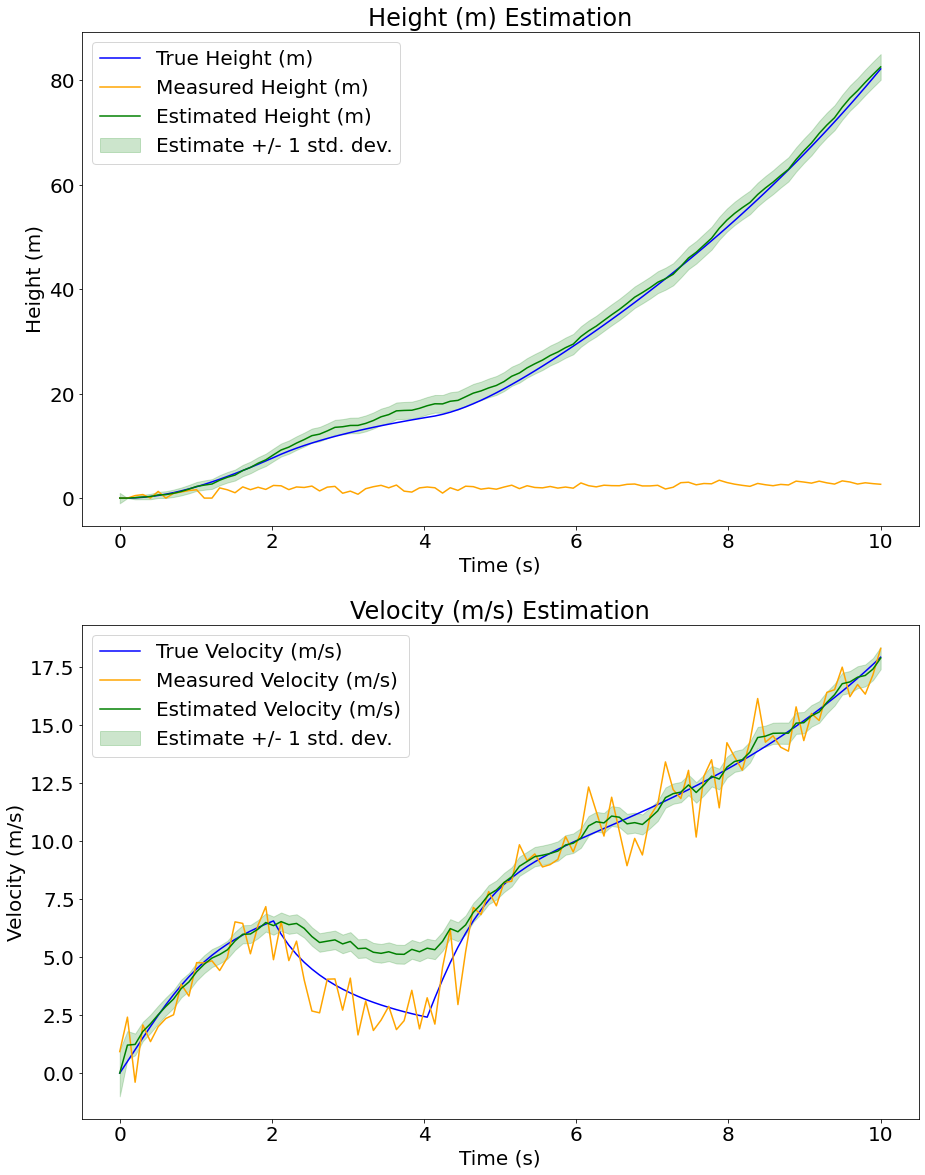

RMS Error Height (m):
  Sensor:    35.323
  Estimator: 1.110
RMS Error Velocity (m/s):
  Sensor:    0.926
  Estimator: 0.996


In [12]:
### Simulation #4
#
# See how our EKF handles a large disturbance.

# Initial state and covariance estimates
x = np.array([[0.0],
              [0.0]])
P = np.array([[1., 0.],
              [0., 1.]])

# Process noise covariance
Q = np.array([[0.1, 0],
              [0, 0.1]])

# Measurement noise covariance
R = np.array([[height_variance, 0],
              [0, velocity_variance]])

ekf = ExtendedKalmanFilter()
ekf.simulate(
    ground_truth=np.vstack((true_height, true_velocity)).T,
    measurements=np.vstack((height_measurements, velocity_measurements)).T,
    state_variable_names=["Height (m)", "Velocity (m/s)"],
    control_inputs=commanded_acceleration,
    t=t, Q=Q, R=R, x_init=x, P_init=P,
    process_model=process_model, process_model_jacobian=process_model_jacobian,
    measurement_model=measurement_model, measurement_model_jacobian=measurement_model_jacobian
)

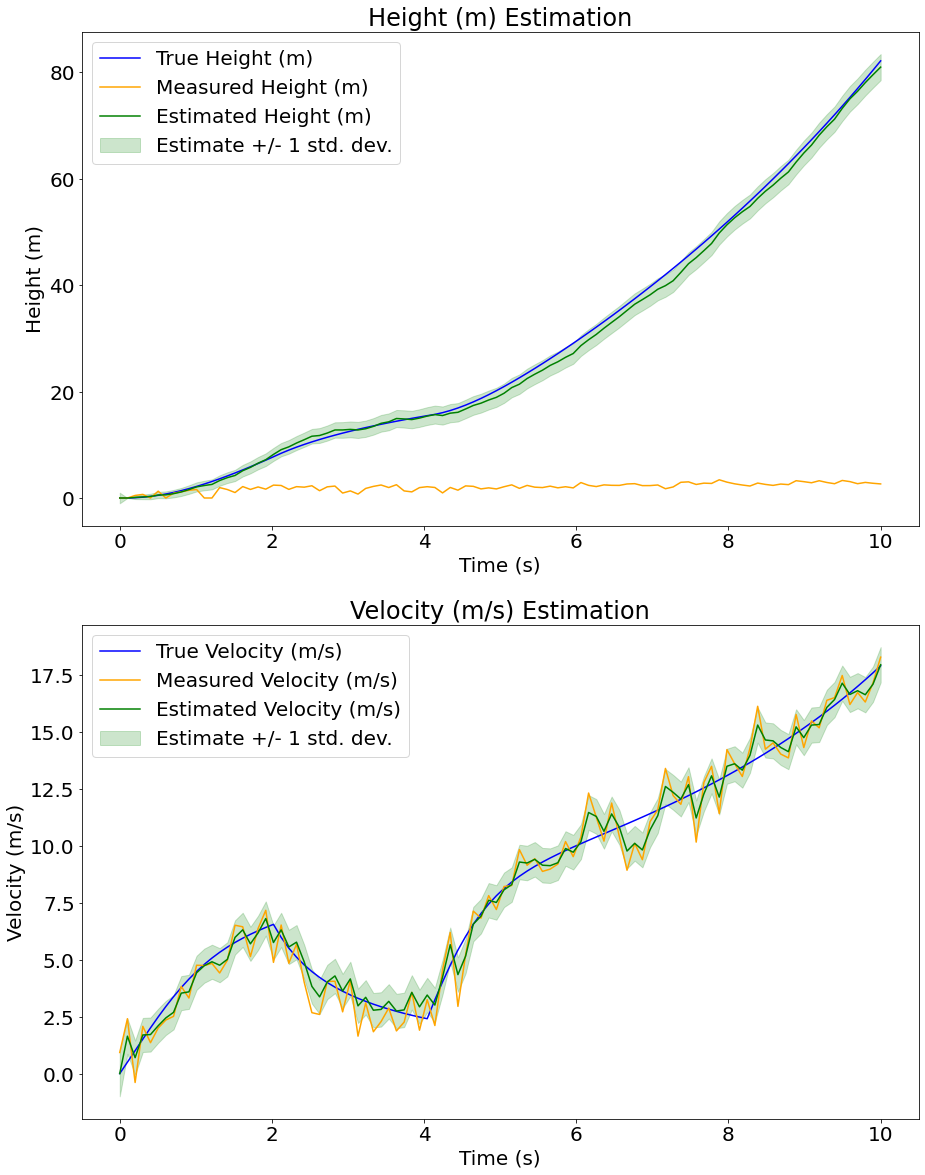

RMS Error Height (m):
  Sensor:    35.323
  Estimator: 0.958
RMS Error Velocity (m/s):
  Sensor:    0.926
  Estimator: 0.549


In [13]:
### Simulation #4
#
# Increase process noise covariance to account for disturbance.

# Initial state and covariance estimates
x = np.array([[0.0],
              [0.0]])
P = np.array([[1., 0.],
              [0., 1.]])

# Process noise covariance
Q = np.array([[0.1, 0],
              [0,   1]])

# Measurement noise covariance
R = np.array([[height_variance, 0],
              [0, velocity_variance]])

ekf = ExtendedKalmanFilter()
ekf.simulate(
    ground_truth=np.vstack((true_height, true_velocity)).T,
    measurements=np.vstack((height_measurements, velocity_measurements)).T,
    state_variable_names=["Height (m)", "Velocity (m/s)"],
    control_inputs=commanded_acceleration,
    t=t, Q=Q, R=R, x_init=x, P_init=P,
    process_model=process_model, process_model_jacobian=process_model_jacobian,
    measurement_model=measurement_model, measurement_model_jacobian=measurement_model_jacobian
)